In [1]:
#notebook for perform ml algorithms
#import necessary packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree

In [2]:
#import and prepare data
#player_ratings_19 = pd.read_csv('Data/2019-20/Players/player_ratings_19_a_09.csv')
player_ratings_19 = pd.read_csv('Data/2019-20/Players/player_ratings_2019.csv')
features_19 = pd.read_csv('Data/2019-20/Fixtures/PL19_20_features.csv')
#exclude gameweeks 1-3
features_19.drop(features_19[features_19.Wk_h < 4].index, inplace=True)
player_ratings_20 = pd.read_csv('Data/2020-21/Players/player_ratings_a_09.csv')
features_20 = pd.read_csv('Data/2020-21/Fixtures/PL20_21_features.csv')
features_20.drop(features_20[features_20.Wk_h < 4].index, inplace=True)
player_ratings_21 = pd.read_csv('Data/2021-22/Players/player_ratings_21_a_09.csv')
features_21 = pd.read_csv('Data/2021-22/Fixtures/PL21_22_features.csv')
features_21.drop(features_21[features_21.Wk_h < 4].index, inplace=True)
player_ratings_20.replace(['Brighton & Hove Albion','Manchester United', 'Newcastle United', 'Sheffield United', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United','Wolverhampton Wanderers'], ['Brighton', 'Manchester Utd','Newcastle Utd', 'Sheffield Utd', 'Tottenham','West Brom' ,'West Ham', 'Wolves'], inplace=True)
player_ratings_20['game_home_ID'] = player_ratings_20['HomeTeam'] + player_ratings_20['Date']
player_ratings_20['game_away_ID'] = player_ratings_20['AwayTeam'] + player_ratings_20['Date']
player_ratings_20.drop(player_ratings_20[player_ratings_20.Wk_h < 4].index, inplace=True)
features_21

,Unnamed: 0,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,...,Elo_h_after,Elo_a_after,Elo_h_before,Elo_a_before,goalsDifference,shotsDifference,cornersDifference,ewmDifference,elo_difference,form_difference
30,30,E0,2021-09-11,12:30,Crystal Palace,Tottenham,3,0,H,0,...,1505.52,1525.14,1488.18,1542.48,-1.500000,-4.000000,-1.500000,-6.783784,-54.30,-4.000000
31,31,E0,2021-09-11,15:00,Arsenal,Norwich City,1,0,H,0,...,1472.46,1441.35,1457.52,1456.29,0.000000,2.500000,6.000000,0.000000,1.23,0.000000
32,32,E0,2021-09-11,15:00,Brentford,Brighton,0,1,A,0,...,1498.17,1529.25,1513.11,1514.31,-1.000000,-5.000000,-5.000000,-1.081081,-1.20,-1.000000
33,33,E0,2021-09-11,15:00,Leicester City,Manchester City,0,1,A,0,...,1498.71,1528.77,1513.71,1513.77,-1.000000,-0.500000,-9.000000,0.027027,-0.06,1.500000
34,34,E0,2021-09-11,15:00,Manchester Utd,Newcastle Utd,4,1,H,1,...,1539.48,1458.09,1526.88,1470.69,3.500000,6.500000,-0.500000,5.792793,56.19,3.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,...,1498.11,1506.66,1481.31,1523.46,-1.333333,-1.666667,1.166667,-12.982307,-42.15,0.000000
376,376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,...,1503.48,1420.47,1490.97,1432.98,1.833333,4.666667,-2.166667,8.867102,57.99,0.333333
377,377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,...,1716.99,1461.21,1711.08,1467.12,5.000000,6.166667,10.000000,37.769667,243.96,4.500000
378,378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,...,1703.55,1460.85,1697.25,1467.15,9.000000,1.333333,4.500000,44.976998,230.10,4.000000


In [3]:
#merge dataframes of 3 seasons
PL_2019_total =  pd.merge(features_19, player_ratings_19, on= 'game_home_ID', how='left')
PL_2020_total =  pd.merge(features_20, player_ratings_20, on= 'game_home_ID', how='left')
PL_2021_total =  pd.merge(features_21, player_ratings_21, on= 'game_home_ID', how='left')
frames = [PL_2019_total, PL_2020_total, PL_2021_total]
PL_19_20_21_all_features = pd.concat(frames)

In [40]:
#calculate differences for player ratings
PL_19_20_21_all_features['gk_difference'] = PL_19_20_21_all_features['rating_h_gk'] - PL_19_20_21_all_features['rating_a_gk']
PL_19_20_21_all_features['df_difference'] = PL_19_20_21_all_features['rating_h_df'] - PL_19_20_21_all_features['rating_a_df']
PL_19_20_21_all_features['mf_difference'] = PL_19_20_21_all_features['rating_h_mf'] - PL_19_20_21_all_features['rating_a_mf']
PL_19_20_21_all_features['att_difference'] = PL_19_20_21_all_features['rating_h_att'] - PL_19_20_21_all_features['rating_a_att']
PL_19_20_21_all_features['bench_difference'] = PL_19_20_21_all_features['rating_h_bench'] - PL_19_20_21_all_features['rating_a_bench']
PL_19_20_21_all_features['influence_difference'] = PL_19_20_21_all_features['influence_h'] - PL_19_20_21_all_features['influence_a']
PL_19_20_21_all_features['creativity_difference'] = PL_19_20_21_all_features['creativity_h'] - PL_19_20_21_all_features['creativity_a']
PL_19_20_21_all_features['threat_difference'] = PL_19_20_21_all_features['threat_h'] - PL_19_20_21_all_features['threat_a']
PL_19_20_21_all_features['bps_difference'] = PL_19_20_21_all_features['bps_h'] - PL_19_20_21_all_features['bps_a']
PL_19_20_21_all_features['selected_difference'] = PL_19_20_21_all_features['selected_h'] - PL_19_20_21_all_features['selected_a']
PL_19_20_21_all_features['overall_h'] = PL_19_20_21_all_features['rating_h_gk'] + PL_19_20_21_all_features['rating_h_df'] + PL_19_20_21_all_features['rating_h_mf'] + PL_19_20_21_all_features['rating_h_att'] + PL_19_20_21_all_features['rating_h_bench']
PL_19_20_21_all_features['overall_a'] = PL_19_20_21_all_features['rating_a_gk'] + PL_19_20_21_all_features['rating_a_df'] + PL_19_20_21_all_features['rating_a_mf'] + PL_19_20_21_all_features['rating_a_att'] + PL_19_20_21_all_features['rating_a_bench']
PL_19_20_21_all_features['overall_difference'] = PL_19_20_21_all_features['overall_h'] - PL_19_20_21_all_features['overall_a']
PL_19_20_21_all_features


,Unnamed: 0_x,Div,Date_x,Time_x,HomeTeam_x,AwayTeam_x,FTHG_x,FTAG_x,FTR_x,HTHG,...,Attack_Rating_Difference,Bench_Rating_Difference,Influence_Difference,Creativity_Difference,Threat_Difference,BPS_Difference,Selected_Difference,Overall_Rating_H,Overall_Rating_A,Overall_Rating_Difference
0,30,E0,2019-08-31,12:30,Southampton,Manchester Utd,1,1,D,0,...,-8.696108,-13.029503,29.643243,-56.994595,-91.072072,72.252252,-7.090981e+06,237.478074,322.462585,-84.984511
1,31,E0,2019-08-31,15:00,Chelsea,Sheffield Utd,2,2,D,2,...,97.174211,2.612414,128.670270,128.120721,139.981982,105.180180,1.377962e+06,419.652975,256.024819,163.628156
2,32,E0,2019-08-31,15:00,Crystal Palace,Aston Villa,1,0,H,0,...,-22.700878,11.903258,8.221622,-70.580180,21.954955,-72.369369,2.088097e+06,211.433752,257.259711,-45.825959
3,33,E0,2019-08-31,15:00,Leicester City,Bournemouth,3,1,H,2,...,-8.118451,15.382999,6.879279,12.309009,-11.549550,15.963964,-1.301976e+06,303.887309,235.442842,68.444467
4,34,E0,2019-08-31,15:00,Manchester City,Brighton,4,0,H,2,...,20.274545,16.194642,169.688288,98.920721,114.045045,114.009009,7.638306e+06,475.117929,223.994842,251.123087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,...,-2.441324,83.527907,-55.839647,-71.843929,-27.652552,-44.959147,6.086770e+05,267.620547,244.663001,22.957546
346,376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,...,29.145907,22.307791,24.274186,8.288232,-30.099457,10.599418,4.572563e+06,279.762870,208.863974,70.898896
347,377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,...,-1.378848,189.332683,-37.028619,-137.912185,-66.928122,-36.540463,6.056832e+06,443.826626,324.107370,119.719256
348,378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,...,25.620656,77.550764,-56.131097,-25.603259,48.868307,-16.173457,4.954865e+06,483.907694,374.647236,109.260458


In [42]:
#rename column names
PL_19_20_21_all_features.rename(columns={"ewmH": "Points_H", "ewmA": "Points_A", "ewmDifference": "Points_Difference", "Rating_Home": "FIFA_Rating_H", "Rating_Away": "FIFA_Rating_A", "Rating difference": "FIFA_Rating_Difference", "goalsH": "Goals_H", "goalsA": "Goals_A",  "goalsDifference": "Goals_Difference", "shotsH": "Shots_H", "shotsA": "Shots_A", "shotsDifference": "Shots_Difference", "cornersH": "Corners_H", "cornersA": "Corners_A", "cornersDifference": "Corners_Difference", "formH": "Form_H", "formA": "Form_A", "form_difference": "Form_Difference", "Elo_h_before": "Elo_H", "Elo_a_before": "Elo_A", "elo_difference": "Elo_Difference","rating_a_gk":"Goalkeeper_Rating_A","rating_h_gk":"Goalkeeper_Rating_H","gk_difference":"Goalkeeper_Rating_Difference","rating_a_df":"Defense_Rating_A","rating_h_df":"Defense_Rating_H","df_difference":"Defense_Rating_Difference","rating_a_mf":"Midfield_Rating_A","rating_H_mf":"Midfield_Rating_H","mf_difference":"Midfield_Rating_Difference","rating_a_att":"Attack_Rating_A","att_difference":"Attack_Rating_Difference","rating_h_bench":"Bench_Rating_H","rating_a_bench":"Bench_Rating_A", "bench_difference":"Bench_Rating_Difference", "overall_h":"Overall_Rating_H", "overall_a":"Overall_Rating_A", "overall_difference":"Overall_Rating_Difference", "selected_h":"Selected_H", "selected_a":"Selected_A", "selected_difference":"Selected_Difference", "bps_h":"BPS_H", "bps_a":"BPS_A", "bps_difference":"BPS_Difference", "influence_h":"Influence_H", "influence_a":"Influence_A", "influence_difference":"Influence_Difference", "creativity_h":"Creativity_H", "creativity_a":"Creativity_A", "creativity_difference":"Creativity_Difference", "threat_h":"Threat_H", "threat_a":"Threat_A", "threat_difference":"Threat_Difference" }, inplace=True)
PL_19_20_21_all_features

array(['D', 'D', 'H', ..., 'H', 'H', 'A'], dtype=object)

In [8]:
#prepare Data for ML Algos, including all features from benchmark + rating differences

y = PL_19_20_21_all_features['FTR_x'].to_numpy()
#all features used for benchmark
feature_names_benchmark = ['FIFA_Rating_Difference', 'FIFA_Rating_H', 'FIFA_Rating_H', 'Points_H', 'Points_A', 'Points_Difference', 'Elo_H', 'Elo_A', 'Elo_Difference', 'Goals_H', 'Goals_A', 'Goals_Difference', 'Shots_H', 'Shots_A', 'Shots_Difference', 'Corners_H', 'Corners_A', 'Corners_Difference', 'Form_H', 'Form_A', 'Form_Difference']

#features including player stats
feature_names_player_stats = ['Goalkeeper_Rating_H', 'FIFA_Rating_Difference', 'FIFA_Rating_H', 'FIFA_Rating_H', 'Points_H', 'Points_A', 'Points_Difference', 'Elo_H', 'Elo_A', 'Elo_Difference', 'Goals_H', 'Goals_A', 'Goals_Difference', 'Shots_H', 'Shots_A', 'Shots_Difference', 'Corners_H', 'Corners_A', 'Corners_Difference', 'Form_H', 'Form_A', 'Form_Difference', 'Goalkeeper_Rating_A', 'Defense_Rating_H', 'Defense_Rating_A', 'Midfield_Rating_H', 'Midfield_Rating_A', 'Attack_Rating_H', 'Attack_Rating_A', 'Bench_Rating_H', 'Bench_Rating_A', 'Influence_H', 'Influence_A', 'Creativity_H', 'Creativity_A', 'Threat_H', 'Threat_A', 'BPS_H', 'BPS_A', 'Selected_H', 'Selected_A', 'Goalkeeper_Rating_Difference', 'Defense_Rating_Difference', 'Midfield_Rating_Difference', 'Attack_Rating_Difference', 'Bench_Rating_Difference','Overall_Rating_Difference' ,'Influence_Difference', 'Creativity_Difference', 'Threat_Difference', 'BPS_Difference', 'Selected_Difference', 'Overall_Rating_H', 'Overall_Rating_A']
feature_names_differences = ['FIFA_Rating_Difference', 'Points_Difference', 'Elo_Difference', 'Goals_Difference', 'Shots_Difference', 'Corners_Difference', 'Form_Difference', 'gk_difference', 'df_difference', 'mf_difference', 'att_difference', 'bench_difference','overall_difference' ,'influence_difference', 'creativity_difference', 'threat_difference', 'bps_difference', 'selected_difference', 'overall_h', 'overall_a']
y

array(['D', 'D', 'H', 'H', 'H', 'D', 'H', 'A', 'H', 'D', 'H', 'D', 'H',
       'A', 'H', 'A', 'H', 'H', 'D', 'D', 'A', 'H', 'H', 'A', 'H', 'D',
       'D', 'H', 'H', 'A', 'A', 'D', 'D', 'H', 'H', 'H', 'H', 'A', 'H',
       'D', 'H', 'H', 'H', 'A', 'D', 'A', 'H', 'A', 'A', 'H', 'H', 'H',
       'D', 'H', 'H', 'D', 'D', 'A', 'D', 'H', 'A', 'H', 'H', 'D', 'D',
       'A', 'D', 'D', 'H', 'A', 'H', 'D', 'A', 'H', 'H', 'H', 'A', 'A',
       'A', 'D', 'A', 'H', 'H', 'H', 'A', 'D', 'H', 'H', 'H', 'H', 'A',
       'D', 'A', 'A', 'A', 'A', 'A', 'H', 'D', 'H', 'D', 'A', 'A', 'H',
       'H', 'H', 'D', 'D', 'H', 'D', 'H', 'A', 'H', 'H', 'H', 'H', 'H',
       'H', 'A', 'A', 'H', 'A', 'H', 'D', 'A', 'A', 'H', 'A', 'D', 'A',
       'H', 'H', 'A', 'D', 'H', 'A', 'D', 'A', 'A', 'D', 'D', 'A', 'A',
       'A', 'H', 'A', 'H', 'H', 'A', 'H', 'H', 'D', 'A', 'H', 'H', 'D',
       'H', 'A', 'H', 'H', 'A', 'D', 'H', 'D', 'A', 'A', 'A', 'H', 'H',
       'D', 'A', 'A', 'H', 'H', 'H', 'D', 'H', 'H', 'H', 'H', 'D

In [9]:
#split Data in training and test set and train model
#training set: season 19/20 and 20/21
#test set: season 21/22

#all features from benchmark
X_benchmark = PL_19_20_21_all_features[feature_names_benchmark].to_numpy()
X_differences = PL_19_20_21_all_features[feature_names_differences].to_numpy()
#all features including player stats
X_player_stats = PL_19_20_21_all_features[feature_names_player_stats].to_numpy()
X_train_player_stats = X_player_stats[:750]
X_test_player_stats = X_player_stats[-350:]
X_train_benchmark = X_benchmark[:750]
X_test_benchmark = X_benchmark[-350:]
X_train_differences = X_differences[:750]
X_test_differences = X_differences[-350:]


y_train_player_stats = y[:750]
y_test_player_stats = y[-350:]
y_train_player_stats

,Unnamed: 0_x,Div,Date_x,Time_x,HomeTeam_x,AwayTeam_x,FTHG_x,FTAG_x,FTR_x,HTHG,...,att_difference,bench_difference,influence_difference,creativity_difference,threat_difference,bps_difference,selected_difference,overall_h,overall_a,overall_difference
0,30,E0,2019-08-31,12:30,Southampton,Manchester Utd,1,1,D,0,...,-8.696108,-13.029503,29.643243,-56.994595,-91.072072,72.252252,-7.090981e+06,237.478074,322.462585,-84.984511
1,31,E0,2019-08-31,15:00,Chelsea,Sheffield Utd,2,2,D,2,...,97.174211,2.612414,128.670270,128.120721,139.981982,105.180180,1.377962e+06,419.652975,256.024819,163.628156
2,32,E0,2019-08-31,15:00,Crystal Palace,Aston Villa,1,0,H,0,...,-22.700878,11.903258,8.221622,-70.580180,21.954955,-72.369369,2.088097e+06,211.433752,257.259711,-45.825959
3,33,E0,2019-08-31,15:00,Leicester City,Bournemouth,3,1,H,2,...,-8.118451,15.382999,6.879279,12.309009,-11.549550,15.963964,-1.301976e+06,303.887309,235.442842,68.444467
4,34,E0,2019-08-31,15:00,Manchester City,Brighton,4,0,H,2,...,20.274545,16.194642,169.688288,98.920721,114.045045,114.009009,7.638306e+06,475.117929,223.994842,251.123087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,375,E0,2022-05-22,16:00,Crystal Palace,Manchester Utd,1,0,H,1,...,-2.441324,83.527907,-55.839647,-71.843929,-27.652552,-44.959147,6.086770e+05,267.620547,244.663001,22.957546
346,376,E0,2022-05-22,16:00,Leicester City,Southampton,4,1,H,0,...,29.145907,22.307791,24.274186,8.288232,-30.099457,10.599418,4.572563e+06,279.762870,208.863974,70.898896
347,377,E0,2022-05-22,16:00,Liverpool,Wolves,3,1,H,1,...,-1.378848,189.332683,-37.028619,-137.912185,-66.928122,-36.540463,6.056832e+06,443.826626,324.107370,119.719256
348,378,E0,2022-05-22,16:00,Manchester City,Aston Villa,3,2,H,0,...,25.620656,77.550764,-56.131097,-25.603259,48.868307,-16.173457,4.954865e+06,483.907694,374.647236,109.260458


In [51]:
#Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

RandomForestClassifier(random_state=6)

In [53]:
#perform random search for hyperparameter tuning

#rs classic model
rand_search_bechmark = RandomizedSearchCV(estimator = rand_clf_benchmark, param_distributions = random_grid, n_iter = 150, cv = 4, verbose=3, random_state=42, n_jobs = -1)
rand_search_bechmark.fit(X_train_benchmark, y_train_player_stats)

#rs improved model
rand_search_improved = RandomizedSearchCV(estimator = rand_clf_improved, param_distributions = random_grid, n_iter = 150, cv = 4, verbose=3, random_state=42, n_jobs = -1)
rand_search_improved.fit(X_train_player_stats, y_train_player_stats)

Fitting 4 folds for each of 150 candidates, totalling 600 fits
Fitting 4 folds for each of 150 candidates, totalling 600 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=6),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [54]:
#display best parameters classic model
rand_search_bechmark.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [55]:
#display best parameters improved model
rand_search_improved.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [56]:
#set up model with best parameters from random search
rand_clf_res_benchmark = RandomForestClassifier(
 n_estimators = 400,
 min_samples_split = 10,
 min_samples_leaf = 4,
 max_features = 'auto',
 max_depth = 70)

In [57]:
#set up model with best parameters from random search
rand_clf_res_improved = RandomForestClassifier(
 n_estimators = 200,
 min_samples_split = 5,
 min_samples_leaf = 4,
 max_features = 'auto',
 max_depth = 80)

In [58]:
#create grid close to values from random search
grid_param_benchmark = {
 'n_estimators': [200, 300, 400, 800],
 'min_samples_split': [5,10,15],
 'min_samples_leaf':  [2,4,6],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [60, 80, 100]
}

In [59]:
#create grid close to values from random search
grid_param_improved = {
 'n_estimators': [50, 100, 200, 600],
 'min_samples_split': [2,5,10],
 'min_samples_leaf':  [2,4,6],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [60, 80, 100]
}

In [61]:
#perform grid search
#classic model
grid_search_benchmark = GridSearchCV(estimator=rand_clf_benchmark, param_grid=grid_param_benchmark, cv=5, n_jobs=-1, verbose=3)
grid_search_benchmark.fit(X_train_player_stats, y_train_player_stats)
#improved model
grid_search_improved = GridSearchCV(estimator=rand_clf_benchmark, param_grid=grid_param_improved, cv=5, n_jobs=-1, verbose=3)
grid_search_improved.fit(X_train_player_stats, y_train_player_stats)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=6), n_jobs=-1,
             param_grid={'max_depth': [60, 80, 100],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 600]},
             verbose=3)

In [63]:
#display best parameters
grid_search_benchmark.best_params_

{'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 300}

In [62]:
#display best parameters
grid_search_improved.best_params_

{'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [12]:
#build model with best parameters from grid search
grid_clf_benchmark = RandomForestClassifier(
 n_estimators = 300,
 min_samples_split = 5,
 min_samples_leaf = 4,
 max_features = 'auto',
 max_depth = 60)

In [13]:
#build model with best parameters from grid search
grid_clf_improved = RandomForestClassifier(
 n_estimators = 100,
 min_samples_split = 10,
 min_samples_leaf = 4,
 max_features = 'auto',
 max_depth = 2)


In [91]:
#fit models
model_benchmark = grid_clf_benchmark.fit(X_train_benchmark, y_train_player_stats)
model_improved = grid_clf_improved.fit(X_train_differences, y_train_player_stats)

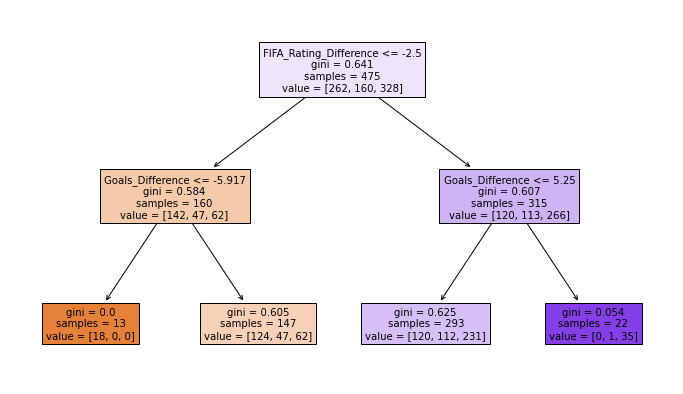

In [111]:
plt.figure(figsize=(12,7))
_ = tree.plot_tree(model_improved.estimators_[7], feature_names=feature_names_differences, filled=True)

In [97]:
# def find_best_model(clf):
#     avg_score = []
#     highscore = 0
#     out = 0
#     for i in range (0,10):
#         #model = clf.fit(X_train_benchmark, y_train_player_stats)
#         #score = model.score(X_test_benchmark, y_test_player_stats)
#         model = clf.fit(X_train_player_stats, y_train_player_stats)
#         score = model.score(X_test_player_stats, y_test_player_stats)
#         avg_score.append(score)
#         #print('Score', score)
#         #if score >= 0.65:
#          #   return model
#     return avg_score
#
#
# test = find_best_model(rand_clf)
# test2 = find_best_model(rand_clf_res)
# test3 = find_best_model(grid_clf)
# print('rand_clf_mean:', np.mean(test))
# print('rand_clf_max:', np.max(test))
# print('rand_clf_res_mean:', np.mean(test2))
# print('rand_clf_res_max:', np.max(test2))
# print('grid_clf_mean:', np.mean(test3))
# print('grid_clf_max:', np.max(test3))

rand_clf_mean: 0.5942857142857143
rand_clf_max: 0.5942857142857143
rand_clf_res_mean: 0.5951428571428572
rand_clf_res_max: 0.6028571428571429
grid_clf_mean: 0.5977142857142858
grid_clf_max: 0.6114285714285714


In [293]:
# def find_best_model(clf):
#     avg_score = []
#     highscore = 0
#     out = 0
#     for i in range (0,200):
#         #model = clf.fit(X_train_benchmark, y_train_player_stats)
#         #score = model.score(X_test_benchmark, y_test_player_stats)
#         model = clf.fit(X_train_player_stats, y_train_player_stats)
#         score = model.score(X_test_player_stats, y_test_player_stats)
#         #avg_score.append(score)
#         print('Score', score)
#         if score > 0.59:
#             return model
#     return model
# #rand_clf = find_best_model(rand_clf)
# rand_clf_res = find_best_model(rand_clf_res)
# #grid_clf = find_best_model(grid_clf)

Score 0.5914285714285714


0.5885714285714285


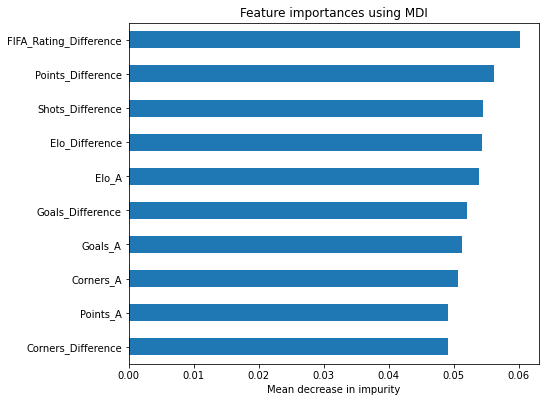

In [66]:
#show scores for hyperparameter tuning
#print('Rand_clf', rand_clf_benchmark.score(X_test_player_stats, y_test_player_stats))
#print('Rand_clf_res',rand_clf_res_benchmark.score(X_test_player_stats, y_test_player_stats))
#print('Grid_clf_res',grid_clf_benchmark.score(X_test_player_stats, y_test_player_stats))
rf_model_benchmark = RandomForestClassifier(random_state=42)
rf_model_benchmark.fit(X_train_benchmark, y_train_player_stats)
print (rf_model_benchmark.score(X_test_benchmark, y_test_player_stats))
#feature importances benchmark
importances = rf_model_benchmark.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_benchmark.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names_benchmark)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()
forest_importances =  forest_importances.sort_values(ascending=False)[:10]
forest_importances =  forest_importances.sort_values()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout(pad=-5, w_pad=2, h_pad=2)

0.5971428571428572


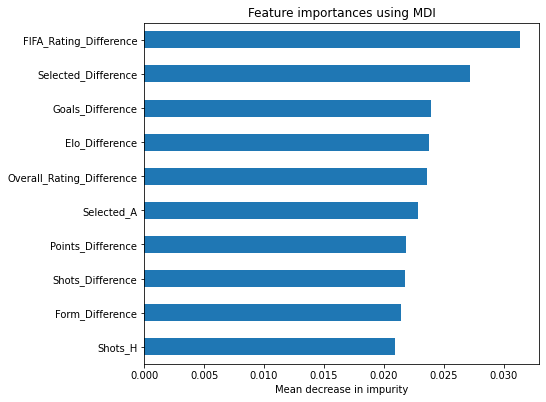

In [69]:
#show scores for hyperparameter tuning
#print('Rand_clf', rand_clf_benchmark.score(X_test_player_stats, y_test_player_stats))
#print('Rand_clf_res',rand_clf_res_benchmark.score(X_test_player_stats, y_test_player_stats))
#print('Grid_clf_res',grid_clf_benchmark.score(X_test_player_stats, y_test_player_stats))

rf_model_player_stats = RandomForestClassifier(random_state=42)
rf_model_player_stats.fit(X_train_player_stats, y_train_player_stats)
print (rf_model_player_stats.score(X_test_player_stats, y_test_player_stats))
#feature importances benchmark
importances = rf_model_player_stats.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_player_stats.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names_player_stats)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()
forest_importances =  forest_importances.sort_values(ascending=False)[:10]
forest_importances =  forest_importances.sort_values()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout(pad=-5, w_pad=2, h_pad=2)

0.5971428571428572


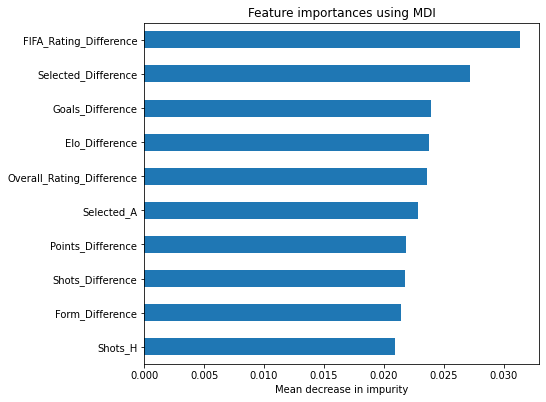

In [45]:
#show scores for hyperparameter tuning
#print('Rand_clf', rand_clf_benchmark.score(X_test_player_stats, y_test_player_stats))
#print('Rand_clf_res',rand_clf_res_benchmark.score(X_test_player_stats, y_test_player_stats))
#print('Grid_clf_res',grid_clf_benchmark.score(X_test_player_stats, y_test_player_stats))

rf_model_player_stats = RandomForestClassifier(random_state=42)
rf_model_player_stats.fit(X_train_player_stats, y_train_player_stats)
print (rf_model_player_stats.score(X_test_player_stats, y_test_player_stats))
#feature importances benchmark
importances = rf_model_player_stats.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_player_stats.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names_player_stats)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()
forest_importances =  forest_importances.sort_values(ascending=False)[:10]
forest_importances =  forest_importances.sort_values()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout(pad=-5, w_pad=2, h_pad=2)

In [ ]:
#build rf model for benchmarks
rf_model_player_stats = grid_clf
rf_model_benchmark = RandomForestClassifier(
 n_estimators = 800,
 min_samples_split = 3,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 80)
rf_model_benchmark = rf_model_benchmark.fit(X_train_benchmark, y_train_player_stats)

#feature importances benchmark
importances = rf_model_player_stats.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_player_stats.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names_player_stats)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()

forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout(pad=-20, w_pad=0.5, h_pad=-2)
print('rf_model_benchmark',rf_model_player_stats.score(X_test_player_stats, y_test_player_stats))

In [15]:
#build rf model for benchmarks
rf_model_player_stats = grid_clf
rf_model_benchmark = RandomForestClassifier(
 n_estimators = 800,
 min_samples_split = 3,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 80)
rf_model_benchmark = rf_model_benchmark.fit(X_train_benchmark, y_train_player_stats)

#feature importances benchmark
importances = rf_model_player_stats.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_player_stats.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names_player_stats)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()

forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout(pad=-20, w_pad=0.5, h_pad=-2)
print('rf_model_benchmark',rf_model_player_stats.score(X_test_player_stats, y_test_player_stats))

NameError: name 'grid_clf' is not defined

In [344]:
#rf_model_player_stats = grid_clf
print('rf_model_benchmark',rf_model_benchmark.score(X_test_benchmark, y_test_player_stats))
print('rf_model_player_stats',rf_model_player_stats.score(X_test_player_stats, y_test_player_stats))

rf_model_benchmark 0.5914285714285714
rf_model_player_stats 0.6028571428571429


In [314]:
#analysis of the models
votes_benchmark = rf_model_benchmark.predict(X=X_test_benchmark)
votes_player_stats = rf_model_player_stats.predict(X=X_test_player_stats)
votes_benchmark = pd.DataFrame(votes_benchmark, columns=['benchmark_vote'])
votes_player_stats = pd.DataFrame(votes_player_stats, columns=['player_stats_vote'])

,benchmark_vote
0,H
1,H
2,A
3,A
4,H
...,...
345,D
346,H
347,H
348,H


In [324]:
probs_player_stats = rf_model_player_stats.predict_proba(X=X_test_player_stats)
probs_benchmark = rf_model_benchmark.predict_proba(X=X_test_benchmark)


array([[0.18630357, 0.17600298, 0.63769345],
       [0.131125  , 0.20928274, 0.65959226],
       [0.67919196, 0.15128125, 0.16952679],
       ...,
       [0.30150893, 0.11861607, 0.579875  ],
       [0.18831548, 0.13936607, 0.67231845],
       [0.59120089, 0.22260417, 0.18619494]])

In [ ]:
probs_benchmark = pd.DataFrame(probs_benchmark, columns=['A', 'D', 'H'])
#probs_benchmark.to_csv('Data/Total/probs_benchmark.csv')
probs_benchmark

In [326]:
probs_player_stats = pd.DataFrame(probs_player_stats, columns=['A', 'D', 'H'])
#probs_player_stats.to_csv('Data/Total/probs_player_stats.csv')
probs_player_stats

,A,D,H
0,0.186304,0.176003,0.637693
1,0.131125,0.209283,0.659592
2,0.679192,0.151281,0.169527
3,0.739292,0.156836,0.103872
4,0.064545,0.068092,0.867363
...,...,...,...
345,0.370964,0.358476,0.270560
346,0.178146,0.199979,0.621875
347,0.301509,0.118616,0.579875
348,0.188315,0.139366,0.672318


In [316]:
probs_player_stats_tmp = PL_19_20_21_all_features[-350:].join(probs_player_stats)
probs_player_stats_tmp = probs_player_stats_tmp[['HomeTeam_x', 'AwayTeam_x', 'FTR_x', 'H', 'D', 'A']]
probs_player_stats_tmp = probs_player_stats_tmp.rename(columns={'HomeTeam_x':'HomeTeam','AwayTeam_x':'AwayTeam', 'FTR_x': 'FTR'})
probs_player_stats_tmp = probs_player_stats_tmp[-350:].join(votes_player_stats)
probs_player_stats_tmp



,HomeTeam,AwayTeam,FTR,H,D,A,player_stats_vote
0,Crystal Palace,Tottenham,H,0.637693,0.176003,0.186304,H
1,Arsenal,Norwich City,H,0.659592,0.209283,0.131125,H
2,Brentford,Brighton,A,0.169527,0.151281,0.679192,A
3,Leicester City,Manchester City,A,0.103872,0.156836,0.739292,A
4,Manchester Utd,Newcastle Utd,H,0.867363,0.068092,0.064545,H
...,...,...,...,...,...,...,...
345,Crystal Palace,Manchester Utd,H,0.270560,0.358476,0.370964,A
346,Leicester City,Southampton,H,0.621875,0.199979,0.178146,H
347,Liverpool,Wolves,H,0.579875,0.118616,0.301509,H
348,Manchester City,Aston Villa,H,0.672318,0.139366,0.188315,H


In [317]:
probs_player_stats_tmp.to_csv('Data/Total/probs_player_stats_info.csv')
probs_player_stats_tmp

,HomeTeam,AwayTeam,FTR,H,D,A,player_stats_vote
0,Crystal Palace,Tottenham,H,0.637693,0.176003,0.186304,H
1,Arsenal,Norwich City,H,0.659592,0.209283,0.131125,H
2,Brentford,Brighton,A,0.169527,0.151281,0.679192,A
3,Leicester City,Manchester City,A,0.103872,0.156836,0.739292,A
4,Manchester Utd,Newcastle Utd,H,0.867363,0.068092,0.064545,H
...,...,...,...,...,...,...,...
345,Crystal Palace,Manchester Utd,H,0.270560,0.358476,0.370964,A
346,Leicester City,Southampton,H,0.621875,0.199979,0.178146,H
347,Liverpool,Wolves,H,0.579875,0.118616,0.301509,H
348,Manchester City,Aston Villa,H,0.672318,0.139366,0.188315,H


In [327]:
probs_benchmark_tmp = PL_19_20_21_all_features[-350:].join(probs_benchmark)
probs_benchmark_tmp = probs_benchmark_tmp[['HomeTeam_x', 'AwayTeam_x', 'FTR_x', 'H', 'D', 'A']]
probs_benchmark_tmp = probs_benchmark_tmp.rename(columns={'HomeTeam_x':'HomeTeam','AwayTeam_x':'AwayTeam', 'FTR_x': 'FTR'})
probs_benchmark_tmp = probs_benchmark_tmp[-350:].join(votes_benchmark)
probs_benchmark_tmp

,HomeTeam,AwayTeam,FTR,H,D,A,benchmark_vote
0,Crystal Palace,Tottenham,H,0.539113,0.211893,0.248994,H
1,Arsenal,Norwich City,H,0.737461,0.177193,0.085345,H
2,Brentford,Brighton,A,0.134107,0.225988,0.639905,A
3,Leicester City,Manchester City,A,0.117018,0.200910,0.682072,A
4,Manchester Utd,Newcastle Utd,H,0.831342,0.107375,0.061283,H
...,...,...,...,...,...,...,...
345,Crystal Palace,Manchester Utd,H,0.181013,0.472850,0.346137,D
346,Leicester City,Southampton,H,0.538856,0.280801,0.180344,H
347,Liverpool,Wolves,H,0.771868,0.099832,0.128301,H
348,Manchester City,Aston Villa,H,0.760083,0.101201,0.138716,H


In [328]:
probs_benchmark_tmp.to_csv('Data/Total/probs_benchmark_info.csv')
probs_benchmark_tmp

,HomeTeam,AwayTeam,FTR,H,D,A,benchmark_vote
0,Crystal Palace,Tottenham,H,0.539113,0.211893,0.248994,H
1,Arsenal,Norwich City,H,0.737461,0.177193,0.085345,H
2,Brentford,Brighton,A,0.134107,0.225988,0.639905,A
3,Leicester City,Manchester City,A,0.117018,0.200910,0.682072,A
4,Manchester Utd,Newcastle Utd,H,0.831342,0.107375,0.061283,H
...,...,...,...,...,...,...,...
345,Crystal Palace,Manchester Utd,H,0.181013,0.472850,0.346137,D
346,Leicester City,Southampton,H,0.538856,0.280801,0.180344,H
347,Liverpool,Wolves,H,0.771868,0.099832,0.128301,H
348,Manchester City,Aston Villa,H,0.760083,0.101201,0.138716,H


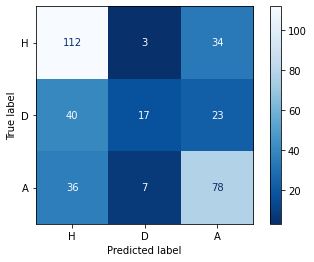

In [329]:
#confusion matrix benchmark
cm= confusion_matrix(y_test_player_stats, votes_benchmark, labels=np.flip(rf_model_benchmark.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(rf_model_benchmark.classes_))
disp.plot(cmap='Blues_r')
plt.show()

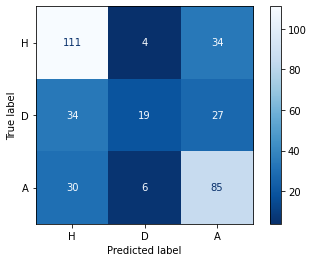

In [330]:
#confusion matrix player stats
cm= confusion_matrix(y_test_player_stats, votes_player_stats, labels=np.flip(rf_model_player_stats.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(rf_model_player_stats.classes_))
disp.plot(cmap='Blues_r')
plt.show()

In [336]:
#classification report for benchmarks and player stats
print(classification_report(y_test_player_stats, votes_player_stats))
print(accuracy_score(y_test_player_stats, votes_player_stats))

              precision    recall  f1-score   support

           A       0.58      0.70      0.64       121
           D       0.66      0.24      0.35        80
           H       0.63      0.74      0.69       149

    accuracy                           0.61       350
   macro avg       0.62      0.56      0.56       350
weighted avg       0.62      0.61      0.59       350

0.6142857142857143


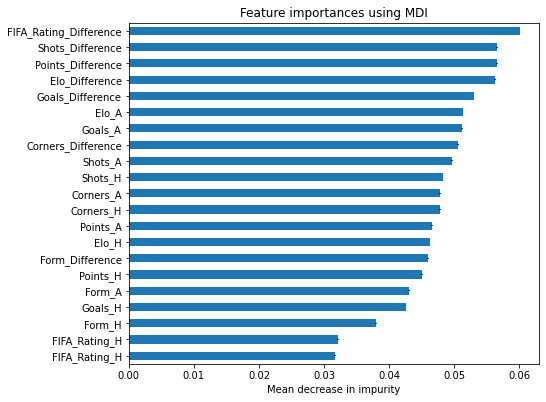

In [345]:
#feature importances benchmark
importances = rf_model_benchmark.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_benchmark.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names_benchmark)
forest_importances = forest_importances.sort_values()
fig, ax = plt.subplots()

forest_importances.plot.barh(ax=ax, yerr=std)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout(pad=-5, w_pad=0.5, h_pad=-2)